# ACA centroiding/ Dynamic Background/ Real Data Example#

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from astropy.io import ascii
from importlib import reload

In [2]:
# local imports:
import sys
sys.path.append("../py")
import classes
from classes import *
import sim_aca_l0 as siml0
import centroids as cntr
import myplot as mplt

### HRC data ###

Use real data (HRC, large dither amplitude of 20 arcsec) to compute centroids using various algorithm <code>(FlightBgd, DynamBgd_Median, DynamBgd_SigmaClip)</code>

__Results__

* Centroiding improves with <code>DynamBgd_Median, DynamBgd_SigmaClip</code> as compared to <code>StandradBgd</code> algorithm.


* <code>DynamBgd_Median, DynamBgd_SigmaClip</code> perform at the same level, independently on the number of samples.


* Centroiding improves for both <code>DynamBgd_Median</code> and <code>DynamBgd_SigmaClip</code> while the number of samples increases.

In [3]:
std_results = """
name                 std_1000  std_25   std_5
FlightBgd            0.56      0.56     0.56
DynamBgd_Median      0.29      0.29     0.35
DynamBgd_SigmaClip   0.29      0.30     0.35
"""
std_results = ascii.read(std_results)
print(std_results)

       name        std_1000 std_25 std_5
------------------ -------- ------ -----
         FlightBgd     0.56   0.56  0.56
   DynamBgd_Median     0.29   0.29  0.35
DynamBgd_SigmaClip     0.29    0.3  0.35


__Computations__

In [4]:
# 50804, ACIS, stars in all slots tracked, star in slot 7 faint, all other stars bright
#obsid = 50804
#slots = [2, 4, 7]

# 8912, HRC, stars in all slots tracked, star in slot 3 faint
obsid = 8912
img_size = 6 # pixels
dwell = events.dwells.filter(obsid=obsid)[0]

In [5]:
msids = ["aoacfct{}".format(slot) for slot in range(8)] + \
        ["aoacmag{}".format(slot) for slot in range(8)]
dat = fetch.MSIDset(msids, start=dwell.start, stop=dwell.stop)

print('TRAK:')
print([dat[msid].vals.tolist().count('TRAK') for msid in msids[:8]])
print('RACQ:')
print([dat[msid].vals.tolist().count('RACQ') for msid in msids[:8]])
print('SRCH:')
print([dat[msid].vals.tolist().count('SRCH') for msid in msids[:8]])
print('MAG:')
print([np.median(dat[msid].vals) for msid in msids[8:]])

TRAK:
[7983, 7983, 7983, 7983, 7983, 7983, 7983, 7983]
RACQ:
[0, 0, 0, 0, 0, 0, 0, 0]
SRCH:
[0, 0, 0, 0, 0, 0, 0, 0]
MAG:
[6.9375, 7.0, 7.0625, 10.4375, 7.625, 8.875, 9.8125, 7.625]


In [6]:
def do_computations(slots, dwell, img_size, nframes, bgd_kwargs):
    rows_all = []
    for slot in slots:
        slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
        for i, Bgd_Class in enumerate([FlightBgd, DynamBgd_Median, DynamBgd_SigmaClip]):
            bgd_object = Bgd_Class(**bgd_kwargs[i])
            print(bgd_object.__class__.__name__)
            rows = cntr.centroids(slot, slot_data, img_size, bgd_object, nframes=nframes)
            for row in rows:
                row['mag'] = np.median(dat["aoacmag{}".format(slot)].vals)
                row['bgd_class_name'] = bgd_object.__class__.__name__
                if isinstance(bgd_object, (DynamBgd_Median, DynamBgd_SigmaClip)):
                    row['ndeque'] = bgd_kwargs[i]['ndeque']
                else:
                    row['ndeque'] = None
                rows_all.append(row)        
    t = Table(rows_all)
    return t

In [7]:
slots = [3, 4] # Faint 10.4 mag, and bright 7.6 mag stars
bgdavg = None
nframes = 1000 # delta_t = 2.05 sec, so use 1000 frames for ~2 dither periods

In [9]:
ndeque = 1000
bgd_kwargs = [{}, {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque},
                  {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque}]

__Large__ number of stored pixel values

In [10]:
ndeque = 25
bgd_kwargs[1]['ndeque'] = ndeque
bgd_kwargs[2]['ndeque'] = ndeque

In [11]:
t_data_25 = do_computations(slots, dwell, img_size, nframes=nframes, bgd_kwargs=bgd_kwargs)

FlightBgd
DynamBgd_Median
DynamBgd_SigmaClip
FlightBgd
DynamBgd_Median
DynamBgd_SigmaClip


__Small__ number of stored pixel values

In [12]:
ndeque = 5
bgd_kwargs[1]['ndeque'] = ndeque
bgd_kwargs[2]['ndeque'] = ndeque

In [13]:
t_data_5 = do_computations(slots, dwell, img_size, nframes=nframes, bgd_kwargs=bgd_kwargs)

FlightBgd
DynamBgd_Median
DynamBgd_SigmaClip
FlightBgd
DynamBgd_Median
DynamBgd_SigmaClip


### Plot residuals###

In [14]:
ok = t_data_25['bgd_class_name'] == 'FlightBgd'
print((t_data_25['time'][ok][1] - t_data_25['time'][ok][0])[:5]) # bright - faint

[ 0.  0.  0.  0.  0.]


Slot 3 - Slot 4
ndeque = 25


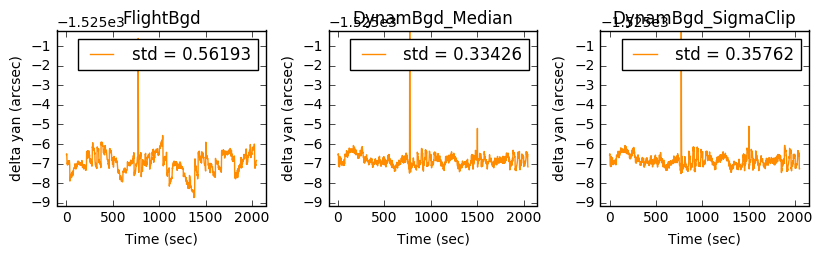

In [15]:
dt = 0. # shift in sec between time axes for faint and bright star
key = 'yan'
mplt.plot_d_ang(3, 4, key, dt, t_data_25)
print("Slot 3 - Slot 4")
print("ndeque = 25")

Slot 3 - Slot 4
ndeque = 5


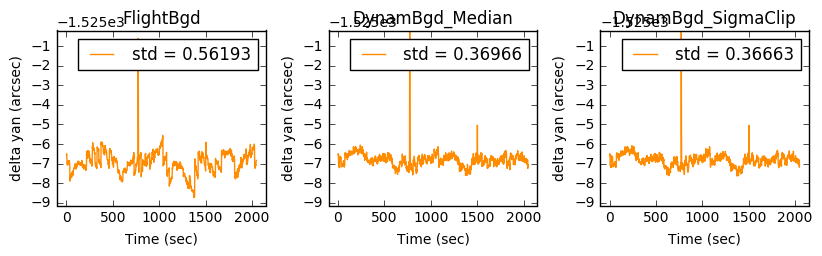

In [17]:
%matplotlib inline
dt = 0. # shift in sec between time axes for faint and bright star
key = 'yan'
mplt.plot_d_ang(3, 4, key, dt, t_data_5)
print("Slot 3 - Slot 4")
print("ndeque = 5")

### Plot centroids###


Large number of samples, ndeque = 25


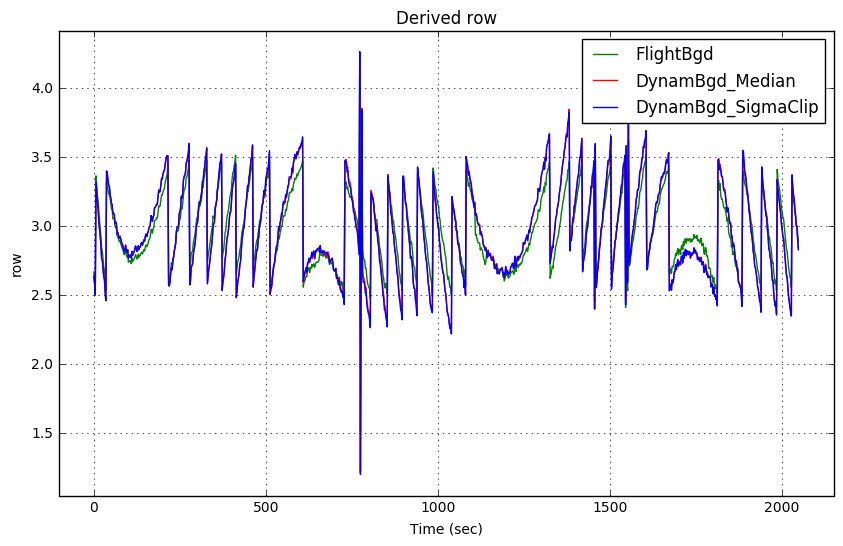

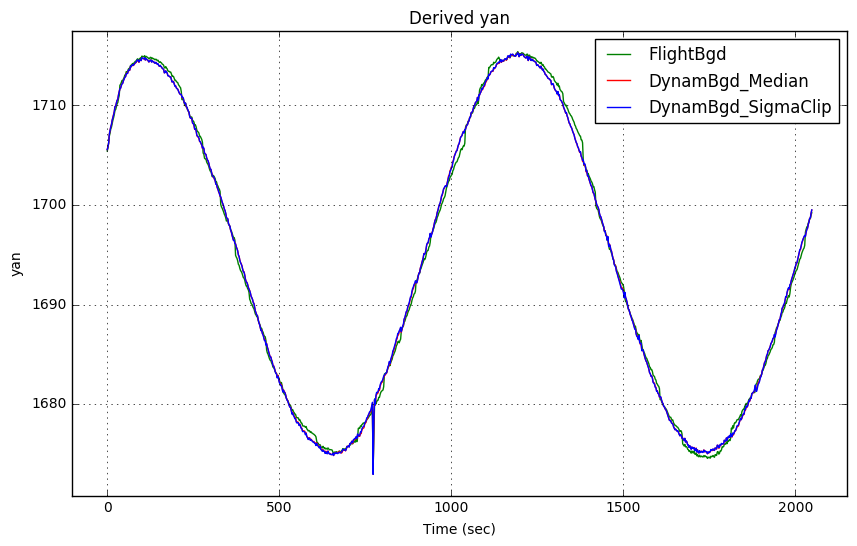

In [18]:
slot = slots[0] # 3, Faint star
mplt.plot_coords(slot, t_data_25, 'row') # computed 'row' coordinate (between 0 and 8)
mplt.plot_coords(slot, t_data_25, 'yan') # computed 'yan' coordinate
print()
print("Large number of samples, ndeque = {}".format(25))


Small number of samples, ndeque = 5


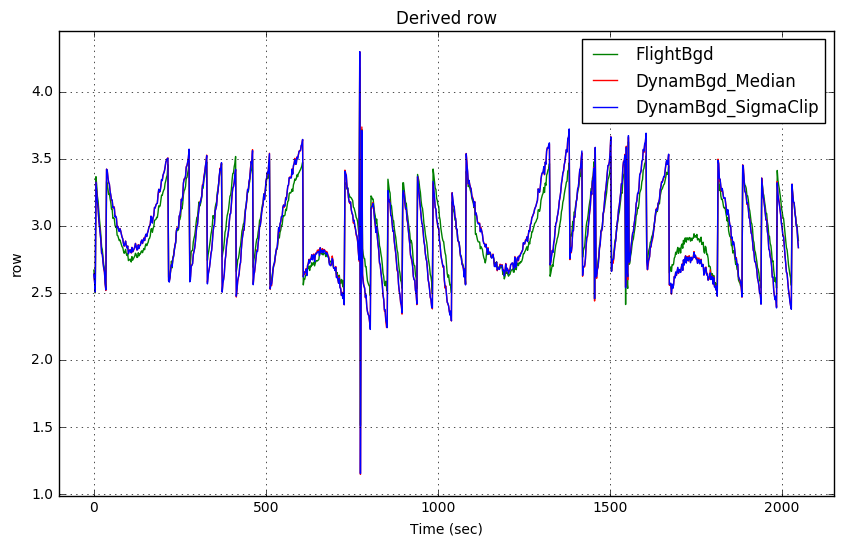

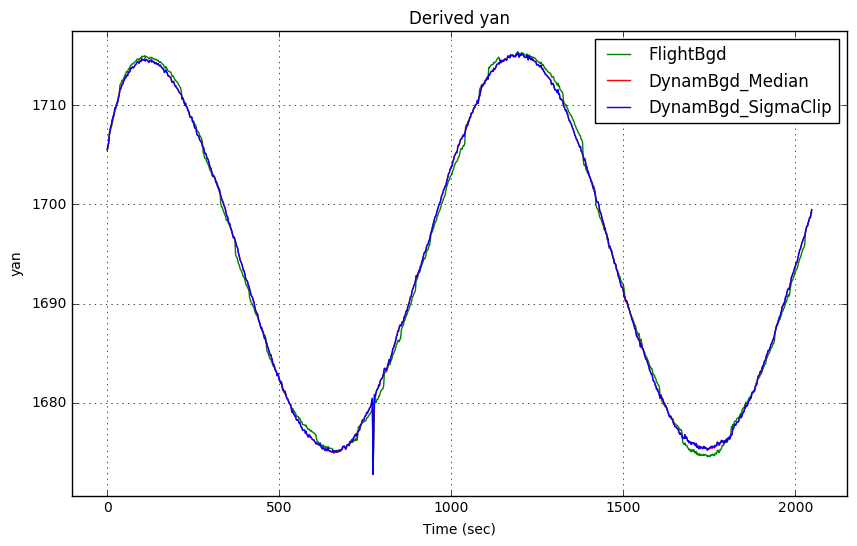

In [19]:
slot = slots[0] # 3, Faint star
mplt.plot_coords(slot, t_data_5, 'row') # computed 'row' coordinate (between 0 and 8)
mplt.plot_coords(slot, t_data_5, 'yan') # computed 'yan' coordinate
print()
print("Small number of samples, ndeque = {}".format(5))

### Plot time history of a given pixel ###

In [20]:
# slot = 3 and mag = Faint => [1]
row0 = t_data_5[1]['row0']
col0 = t_data_5[1]['col0']

In [21]:
# get coordinates (keys) of the edge pixels sampled during the dither
def get_patch_keys(row0, col0, img_size):
    r_min, r_max, c_min, c_max = mplt.patch_coords(row0, col0, img_size)
    
    keys = []
    for rr in np.arange(r_min, r_max + 1):
        for cc in np.arange(c_min, c_max + 1):
            keys.append((rr, cc))
    
    return keys

In [22]:
#keys = get_patch_keys(row0, col0, img_size)
#print(len(keys))
#print(keys)

ndeque = 25


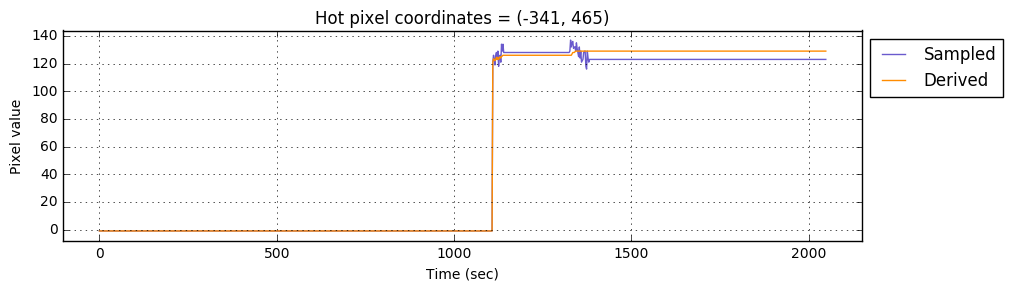

In [23]:
%matplotlib inline
mplt.plot_px_history(t_data_25, [(-341, 465)], slot=3, bgd_class_name='DynamBgd_Median') # keys[26:27]
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));
print("ndeque = 25")

ndeque = 5


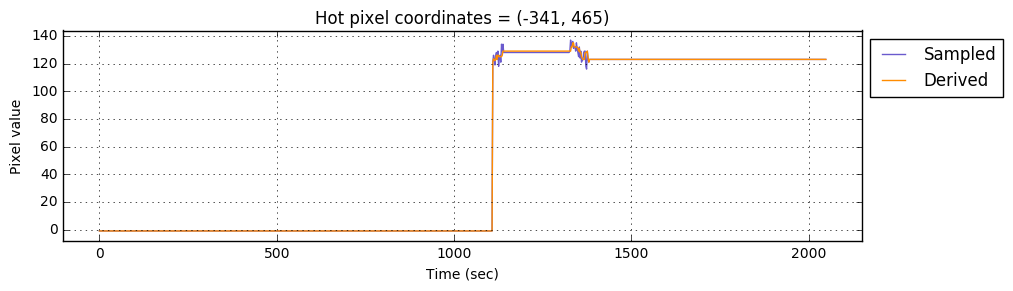

In [25]:
%matplotlib inline
mplt.plot_px_history(t_data_5, [(-341, 465)], slot=3, bgd_class_name='DynamBgd_Median') # keys[26:27]
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));
print("ndeque = 5")

ndeque = 25


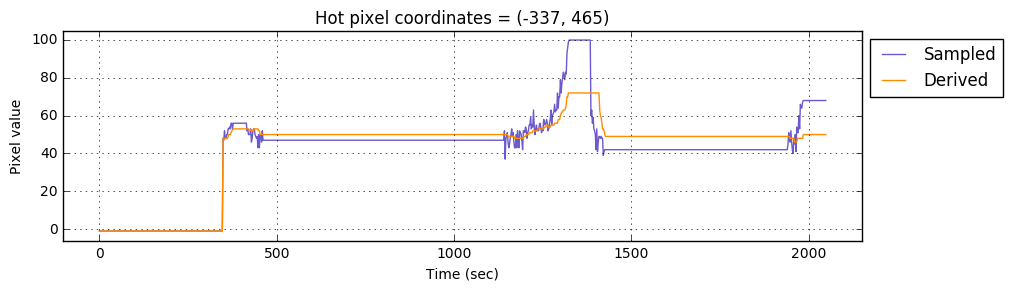

In [26]:
%matplotlib inline
mplt.plot_px_history(t_data_25, [(-337, 465)], slot=3, bgd_class_name='DynamBgd_Median')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));
print("ndeque = 25")

ndeque = 5


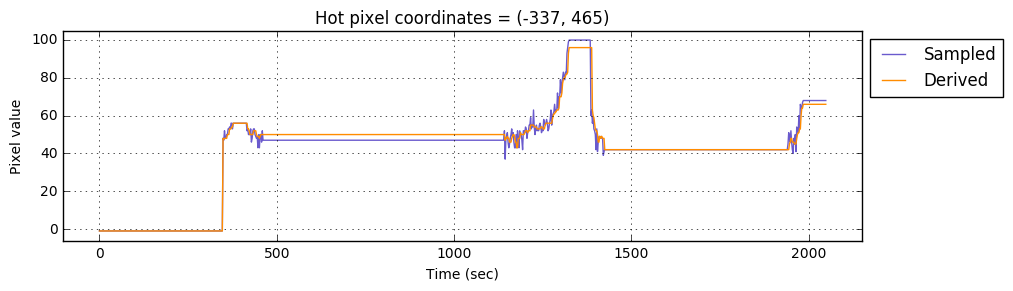

In [27]:
%matplotlib inline
mplt.plot_px_history(t_data_5, [(-337, 465)], slot=3, bgd_class_name='DynamBgd_Median')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));
print("ndeque = 5")

__Plot the derived background images__

* <span style="color:black;font-weight:bold">Black patch</span> - CCD region that will eventually be sampled due to the dither
* <span style="color:crimson;font-weight:bold">6x6 patches</span> - pixel region corresponding to background derived for a current frame (sampled edge pixels + average background value for pixels inside the edge)

In [28]:
slot = 3 # Faint star

Format of the titles is 'time: imgrow0, imgcol0'
Plot imgraw from 640 to 670
Bgd Class: DynamBgd_Median, ndeque = 5


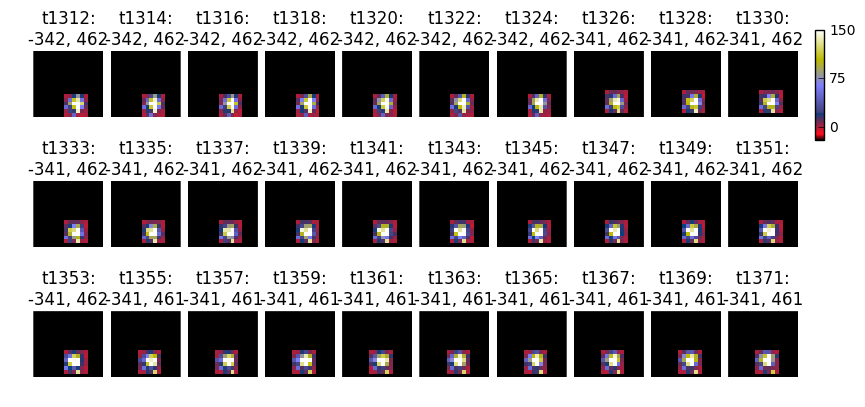

In [29]:
data =  mplt.plot_images(t_data_5, n_start=640, n_stop=670, slot=slot,
                         img_size=img_size, bgd_class_name='DynamBgd_Median',
                         vmin=-20, vmax=150, colname='imgraw')

Format of the titles is 'time: imgrow0, imgcol0'
Plot bgdimg from 640 to 670
Bgd Class: DynamBgd_Median, ndeque = 5


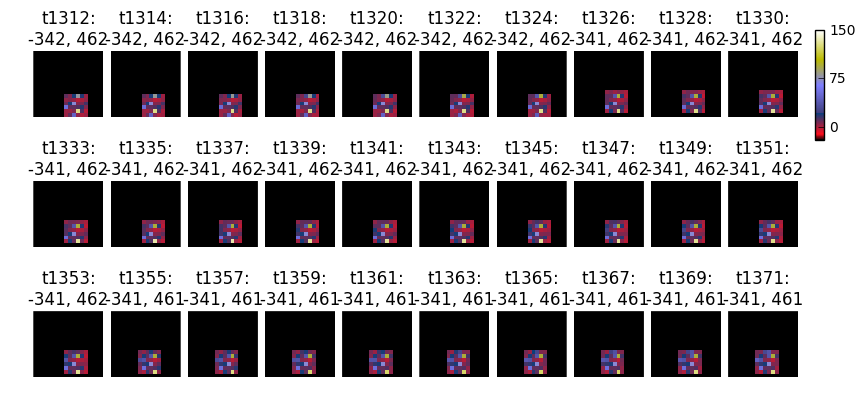

In [30]:
data = mplt.plot_images(t_data_5, n_start=640, n_stop=670, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-20, vmax=150, colname='bgdimg')

Format of the titles is 'time: imgrow0, imgcol0'
Plot img from 640 to 670
Bgd Class: DynamBgd_Median, ndeque = 5


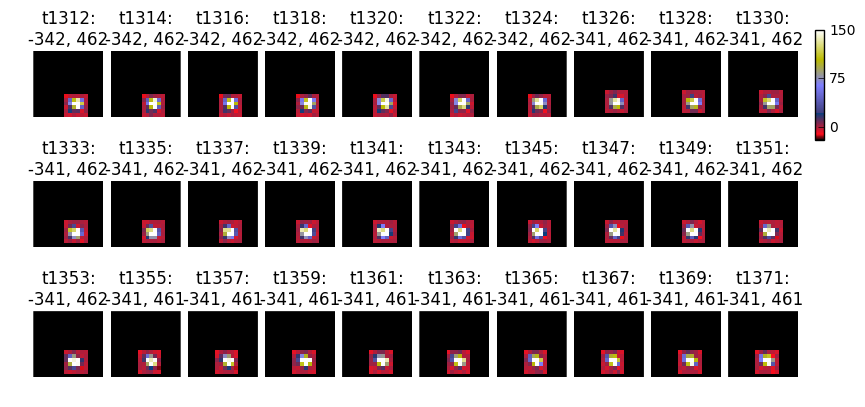

In [31]:
data = mplt.plot_images(t_data_5, n_start=640, n_stop=670, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-20, vmax=150, colname='img')

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 0 to 10
Bgd Class: DynamBgd_Median, ndeque = 5


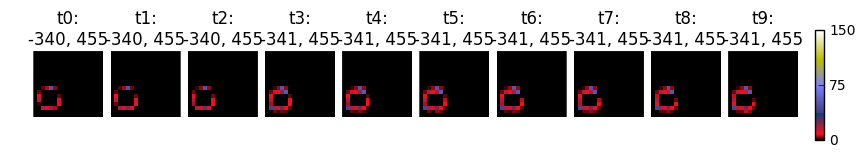

In [34]:
data = mplt.plot_bgd_patches(t_data_5, n_start=0, n_stop=10, slot=slot,
                      img_size=img_size, bgd_class_name='DynamBgd_Median', vmax=150)

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 990 to 1000
Bgd Class: DynamBgd_Median, ndeque = 5


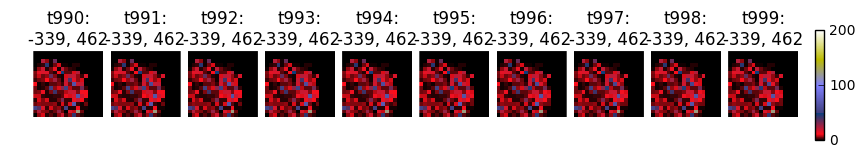

In [35]:
data = mplt.plot_bgd_patches(t_data_5, n_start=990, n_stop=nframes, slot=slot, 
                             img_size=img_size, bgd_class_name='DynamBgd_Median', vmax=200)